In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd                           # importing libraries to use in this model
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score,roc_curve

In [3]:
df_train=pd.read_csv('Titanic_train.csv')    # training dataset imported as df_train
df_test=pd.read_csv('Titanic_test.csv')      # test dataset imported as df_test

In [4]:
df_train.drop(['Embarked','Name','Ticket','Cabin','PassengerId'],axis=1,inplace=True)   # dropped variables from train dataset, since it not impact our model
df_test.drop(['Embarked','Name','Ticket','Cabin','PassengerId'],axis=1,inplace=True)   # same variables dropped from testing dataset as well

In [5]:
df_train.info()      # training dataset information 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
dtypes: float64(2), int64(4), object(1)
memory usage: 48.9+ KB


In [6]:
df_train['Age'] = df_train['Age'].fillna(df_train['Age'].mean()) # since there is missing values in 'Age' variable, mean values calculated to fill the dataset
df_test['Age']= df_test['Age'].fillna(df_test['Age'].mean())  

In [7]:
df_train.head()   # preprocessed training dataset information 

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,male,22.0,1,0,7.2500
1,1,1,female,38.0,1,0,71.2833
2,1,3,female,26.0,0,0,7.9250
3,1,1,female,35.0,1,0,53.1000
4,0,3,male,35.0,0,0,8.0500


In [8]:
le = LabelEncoder()                                  # variable 'Sex' encoded as boolean value to assist analyse model
df_train['Sex'] = le.fit_transform(df_train['Sex'])
df_test['Sex'] = le.fit_transform(df_test['Sex'])

### Histogram plot

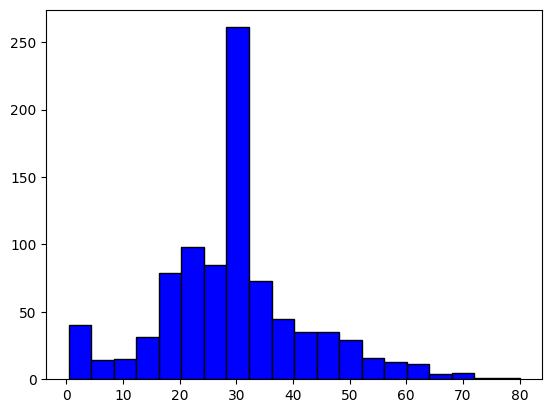

In [9]:
plt.hist(df_train['Age'],bins=20, color='b',edgecolor='black')   # plotting histogram for distributions of age group
plt.show()

In [10]:
# The age distribution appears to be right-skewed, means there are more individuals in younger age groups.
# The higher bar seems to be around most people from 30-32 years old.

### Bar plot

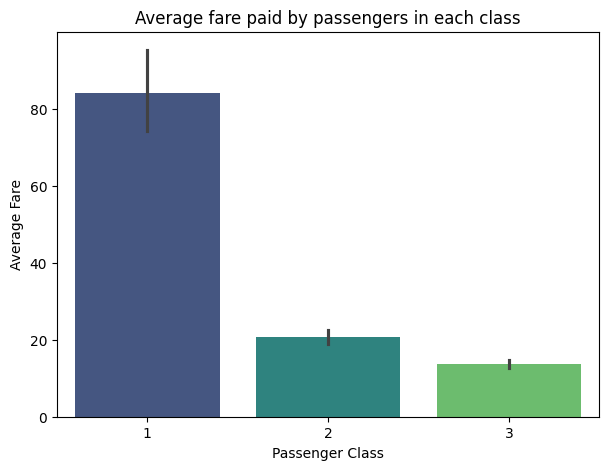

In [11]:
plt.figure(figsize=(7,5))
sns.barplot(data=df_train,x='Pclass',y='Fare',palette='viridis')
plt.title('Average fare paid by passengers in each class')
plt.xlabel('Passenger Class')
plt.ylabel('Average Fare')
plt.show()

In [12]:
# Passengers in 1st class paid a significantly higher fare than those in 2nd or 3rd class.
# The error bars are relatively small, indicating that the fare distribution within each class doesn't have extreme variability

### Scatter plot to analyse Sibsp vs Fare

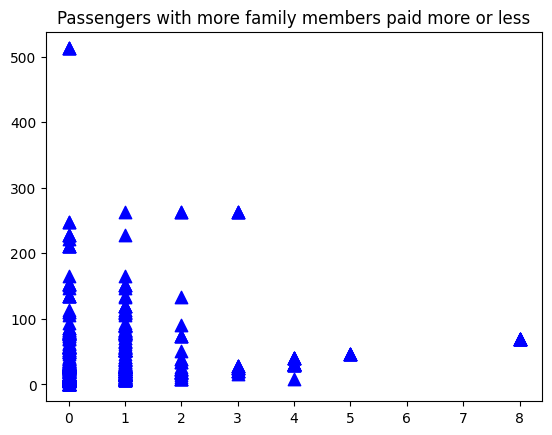

In [13]:
plt.scatter(df_train['SibSp'],df_train['Fare'],marker='^',s=80, color='b')
plt.title('Passengers with more family members paid more or less')
plt.show()

In [14]:
# Many passengers with 0 or 1 family members paid a wide range of fares.
# There are some passengers with large families (e.g. 5 or more) who mostly paid lower fares.

In [15]:
X_train = df_train.drop(['Survived'],axis=1)          # X_train dataset having been assigned as independent variables
y_train = df_train['Survived']                        # y_train dataset is having the dependent variable which has to be target variable here

In [16]:
df_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare
0,3,1,34.5,0,0,7.8292
1,3,0,47.0,1,0,7.0000
2,2,1,62.0,0,0,9.6875
3,3,1,27.0,0,0,8.6625
4,3,0,22.0,1,1,12.2875


## Hyperparameter Tuning

In [17]:
model = xgb.XGBClassifier(subsample = 0.5, objective='binary:logistic',random_state=42)     # model components are given to tune the hyperparameter

In [18]:
param_grid = { 'n_estimators':[10,25,50,100],
              'max_depth':[4,8,12,16],
              'learning_rate':[0.1,0.01,0.001,1.0]}

In [19]:
grd = GridSearchCV(estimator = model, param_grid=param_grid, scoring = 'accuracy', cv=5)

In [20]:
grd.fit(X_train,y_train)                     # grid values fitting into training dataset

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'learning_rate': [0.1, 0.01, 0.001, 1.0],
                         'max_depth': [4, 8, 12, 16],
                         'n_estimators': [10, 25, 50, 100]},
             scoring='accuracy')

In [21]:
final_model = grd.best_estimator_              # estimated parameters are assigned to final model

## Get train metrics

In [22]:
yhat_train = final_model.predict(X_train)      # using the final model to predict yhat value

In [23]:
confusion_matrix(y_train,yhat_train)           # confusion matrix find the relationship of actual and predicted training value

array([[523,  26],
       [ 49, 293]])

In [24]:
print(classification_report(y_train,yhat_train))   #classification report has calculated the precision, f1-score, accuracy of predicted values

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       549
           1       0.92      0.86      0.89       342

    accuracy                           0.92       891
   macro avg       0.92      0.90      0.91       891
weighted avg       0.92      0.92      0.92       891



In [25]:
final_model.predict_proba(X_train)            # final model predict probalitiy of training dataset

array([[0.9095326 , 0.09046739],
       [0.00895256, 0.99104744],
       [0.498205  , 0.501795  ],
       ...,
       [0.8379373 , 0.16206269],
       [0.07325768, 0.9267423 ],
       [0.91994333, 0.08005664]], dtype=float32)

In [26]:
ytrain_proba = final_model.predict_proba(X_train)[:,1]
ytrain_proba

array([0.09046739, 0.99104744, 0.501795  , 0.9930259 , 0.03372811,
       0.07588071, 0.08851162, 0.09738011, 0.8315285 , 0.9772753 ,
       0.9564302 , 0.8894606 , 0.11097538, 0.09451712, 0.5933903 ,
       0.81025267, 0.07005089, 0.35501787, 0.59433204, 0.84252733,
       0.1218302 , 0.21447487, 0.9434284 , 0.6069628 , 0.08225655,
       0.42536664, 0.08258297, 0.1282096 , 0.86973375, 0.04681736,
       0.21507204, 0.96299785, 0.8320884 , 0.11075745, 0.20254807,
       0.25117832, 0.07941477, 0.03929869, 0.28103802, 0.81455916,
       0.06263528, 0.5090038 , 0.04681736, 0.9799239 , 0.86770004,
       0.04477823, 0.1900793 , 0.8320884 , 0.14996392, 0.2550487 ,
       0.03185096, 0.06275748, 0.9833317 , 0.9355657 , 0.08363757,
       0.3740814 , 0.87254816, 0.21557675, 0.98380196, 0.01681238,
       0.2742122 , 0.9932058 , 0.21435839, 0.0978739 , 0.1773892 ,
       0.5078695 , 0.96034974, 0.08711687, 0.8433426 , 0.03610687,
       0.2986333 , 0.0376284 , 0.08455627, 0.02258839, 0.85711

In [27]:
fpr,tpr,thresh = roc_curve(y_train,ytrain_proba)     # roc_curve is being calculated 

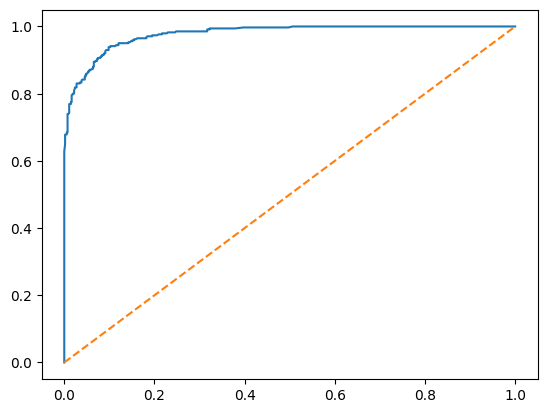

In [28]:
plt.plot(fpr,tpr)                                   # plotting roc_curve 
plt.plot([0,1],[0,1],linestyle='dashed')
plt.show()

In [37]:
#  the blue curve "hugs" the top-left corner and is significantly above the diagonal orange line implies a high AUC value

In [29]:
auc = roc_auc_score(y_train,ytrain_proba)  # roc_auc_score has been calculated from actual training value and probabiltiy of predicted training value
auc                                        # 97% predicted correctly in the training data

np.float64(0.9775801830015233)

## Get metrics for testing data

In [30]:
yhat_test = final_model.predict(X_train)

In [32]:
final_model.predict_proba(df_test)     # predicted probability of test dataset

array([[0.9633871 , 0.03661291],
       [0.8275268 , 0.1724732 ],
       [0.8702704 , 0.1297296 ],
       [0.7144547 , 0.2855453 ],
       [0.4232673 , 0.5767327 ],
       [0.8806032 , 0.11939681],
       [0.7950911 , 0.20490892],
       [0.9224336 , 0.07756636],
       [0.25395066, 0.74604934],
       [0.96310294, 0.03689707],
       [0.97210264, 0.02789736],
       [0.8783492 , 0.12165079],
       [0.01537919, 0.9846208 ],
       [0.9785229 , 0.02147711],
       [0.02582175, 0.97417825],
       [0.10586977, 0.89413023],
       [0.9309045 , 0.06909552],
       [0.5859219 , 0.41407815],
       [0.5174615 , 0.48253852],
       [0.58013165, 0.41986832],
       [0.730214  , 0.269786  ],
       [0.59768206, 0.40231794],
       [0.01148391, 0.9885161 ],
       [0.41436   , 0.58564   ],
       [0.05566531, 0.9443347 ],
       [0.98422354, 0.01577646],
       [0.00976461, 0.9902354 ],
       [0.63237077, 0.36762923],
       [0.25549692, 0.7445031 ],
       [0.8799977 , 0.12000235],
       [0.

In [33]:
# since there is no y_test(targeted variable) value from test dataset, not able to evaluate model's performance

In [34]:
model1 = lgb.LGBMClassifier(subsample = 0.5, objective='binary',random_state=42,force_row_wise=True)

In [35]:
model1.fit(X_train,y_train)     # lightgboost model fit into training dataset

[LightGBM] [Info] Number of positive: 342, number of negative: 549
[LightGBM] [Info] Total Bins 219
[LightGBM] [Info] Number of data points in the train set: 891, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383838 -> initscore=-0.473288
[LightGBM] [Info] Start training from score -0.473288


LGBMClassifier(force_row_wise=True, objective='binary', random_state=42,
               subsample=0.5)

In [38]:
lg_yhat_train = model1.predict(X_train)    # yhat value predicted values from training dataset

In [39]:
confusion_matrix(y_train,lg_yhat_train)

array([[535,  14],
       [ 32, 310]])

In [40]:
print(classification_report(y_train,lg_yhat_train))  # this model performs 91% on training data

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       549
           1       0.96      0.91      0.93       342

    accuracy                           0.95       891
   macro avg       0.95      0.94      0.94       891
weighted avg       0.95      0.95      0.95       891



In [42]:
model1.predict_proba(X_train)    #  final model predicts probalitiy of training dataset in lightgb model

array([[0.93593246, 0.06406754],
       [0.00115825, 0.99884175],
       [0.31331256, 0.68668744],
       ...,
       [0.72082825, 0.27917175],
       [0.05267168, 0.94732832],
       [0.90922769, 0.09077231]])

In [43]:
ytrain_proba1 = model1.predict_proba(X_train)[:,1]
ytrain_proba1

array([6.40675449e-02, 9.98841747e-01, 6.86687441e-01, 9.98951199e-01,
       5.44530649e-02, 9.56678219e-02, 6.13101330e-02, 6.63785679e-02,
       8.67369252e-01, 9.71173974e-01, 9.34570027e-01, 8.44668475e-01,
       1.58131857e-01, 2.41719449e-02, 4.90631338e-01, 8.78387422e-01,
       3.34460725e-02, 5.28916442e-01, 4.19333598e-01, 8.33141660e-01,
       6.84004674e-02, 1.85260028e-01, 8.76251988e-01, 5.83783581e-01,
       8.24583089e-02, 6.16661965e-01, 3.82605091e-02, 3.67572166e-02,
       9.13493652e-01, 2.42051955e-02, 2.05144815e-01, 9.63172195e-01,
       7.92438774e-01, 1.30438821e-01, 1.24657778e-01, 2.36468037e-01,
       5.98831106e-02, 2.74660690e-02, 1.57346275e-01, 8.37184040e-01,
       1.38485616e-01, 3.71166454e-01, 2.42051955e-02, 9.83152964e-01,
       8.54931396e-01, 2.26992278e-02, 1.12045876e-01, 7.92438774e-01,
       1.71700172e-01, 1.27227175e-01, 1.39559255e-02, 3.20634400e-02,
       9.98044717e-01, 9.75273925e-01, 9.23810018e-02, 4.16280532e-01,
      

In [44]:
fpr1,tpr1,thresh = roc_curve(y_train,ytrain_proba1)

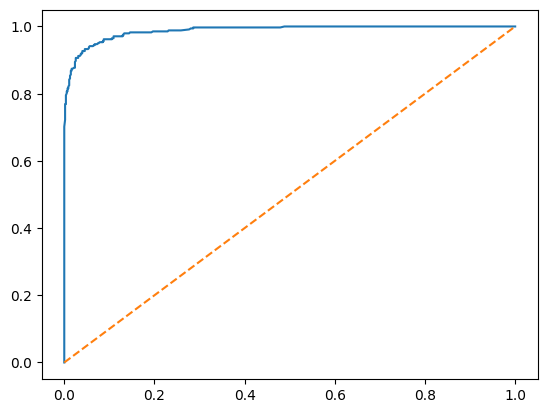

In [45]:
plt.plot(fpr1,tpr1)                                   # plotting roc_curve 
plt.plot([0,1],[0,1],linestyle='dashed')
plt.show()

In [46]:
# The x-axis (False Positive Rate) measures how many incorrect positive predictions were made relative to all actual negatives.
# The y-axis (True Positive Rate) measures how many correct positive predictions were made relative to all actual positives.
# The blue curve is model’s ROC curve, showing how well it separates the classes at various thresholds.

In [50]:
auc = roc_auc_score(y_train,ytrain_proba1)  # roc_auc_score has been calculated from actual training value and probabiltiy of predicted training value
auc                                        # 98% predicted correctly in the training data

np.float64(0.9874998668498813)

In [48]:
# both Xgboost and lightgbm predicts the training model well.

In [49]:
# not able to predict test data as target value not present in test dataset.